In [1]:
%reload_ext autoreload
%autoreload 2

# Meta-analysis of benthic calcification rates

In [ ]:
# custom imports
from calcification_meta_analysis.processing import process, climatology
from calcification_meta_analysis.plotting import climatology as climatology_plot
from calcification_meta_analysis.utils import config

# generic
import pandas as pd

### Load calcification rates dataset

In [3]:
# load raw extracted data
extracted_fp = config.data_dir / "extracted_data.csv"
extracted_df = pd.read_csv(extracted_fp)
extracted_df.describe()

,Year,Latitude,Longitude,pCO2 (uatm),pH (Total),TA (umol kg-1),Irradiance (umol photons m-2 s-1),Temperature (oC),Salinity (ppt),Number of replicates,Calcification rate,Calcification rate standard deviation,Standardised calcification rate standard deviation
count,4497.000000,4497.000000,4497.000000,4354.000000,4363.000000,4306.000000,2667.000000,4497.000000,4168.000000,4497.000000,4497.000000,1445.000000,1445.000000
mean,2017.634868,15.134466,-63.738210,814.354555,7.853830,2287.100196,219.056027,28.144647,34.183104,3.709139,26.643082,11.649194,7.010300
std,2.839276,16.700267,98.936171,576.207224,0.210505,253.263201,259.670639,2.026150,1.601867,7.805856,138.628244,86.959204,54.939682
min,2003.000000,-32.024638,-162.128098,107.034969,7.137075,2.326000,0.000000,20.400000,20.000000,1.000000,-1747.630000,0.000000,0.000000
25%,2017.000000,16.189870,-149.825875,400.000000,7.694000,2150.187500,42.824074,27.000000,33.000000,1.000000,0.166000,0.145944,0.100617
50%,2017.000000,21.435000,-81.779987,691.145205,7.863396,2288.040000,83.454545,27.900000,34.500000,1.000000,0.717000,0.415692,0.342751
75%,2019.000000,24.620550,-80.162825,1027.645405,8.030000,2422.000000,265.225441,30.300000,35.040000,3.000000,3.684300,1.143154,0.963763
max,2024.000000,55.378051,178.065032,3979.675745,8.324000,3356.000000,1946.000000,34.000000,41.000000,165.000000,2755.268000,1567.483652,1610.274726


In [4]:
# automatically process the data into treatments and effects
data_df = process.process_extracted_df_to_effect_sizes(extracted_df)

Assigning treatment groups:   0%|          | 0/366 [00:00<?, ?it/s]

INFO:calcification_meta_analysis.processing.cleaning:Unit standardization complete: 1656/1656 rows converted successfully


Removing 1 row with n=1


  0%|          | 0/158 [00:00<?, ?it/s]

Control dataframe is empty for DOI: 10.1007/s00338-019-01775-y. Consider assigning manually (currently losing 4 rows)
Control dataframe is empty for DOI: 10.1007/s00338-019-01775-y. Consider assigning manually (currently losing 8 rows)


/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/analysis/analysis.py:347: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(0, mean_value).infer_objects(copy=False)


### Effect type choices

In [5]:
# select effect type
effect_type = "st_relative_calcification"

### Load climatology data

INFO:root:Loading climatology data...
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/processing/climatology.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/processing/climatology.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcast

Generating batched anomalies for ph:   0%|          | 0/133 [00:00<?, ?it/s]

Generating batched anomalies for sst:   0%|          | 0/133 [00:00<?, ?it/s]

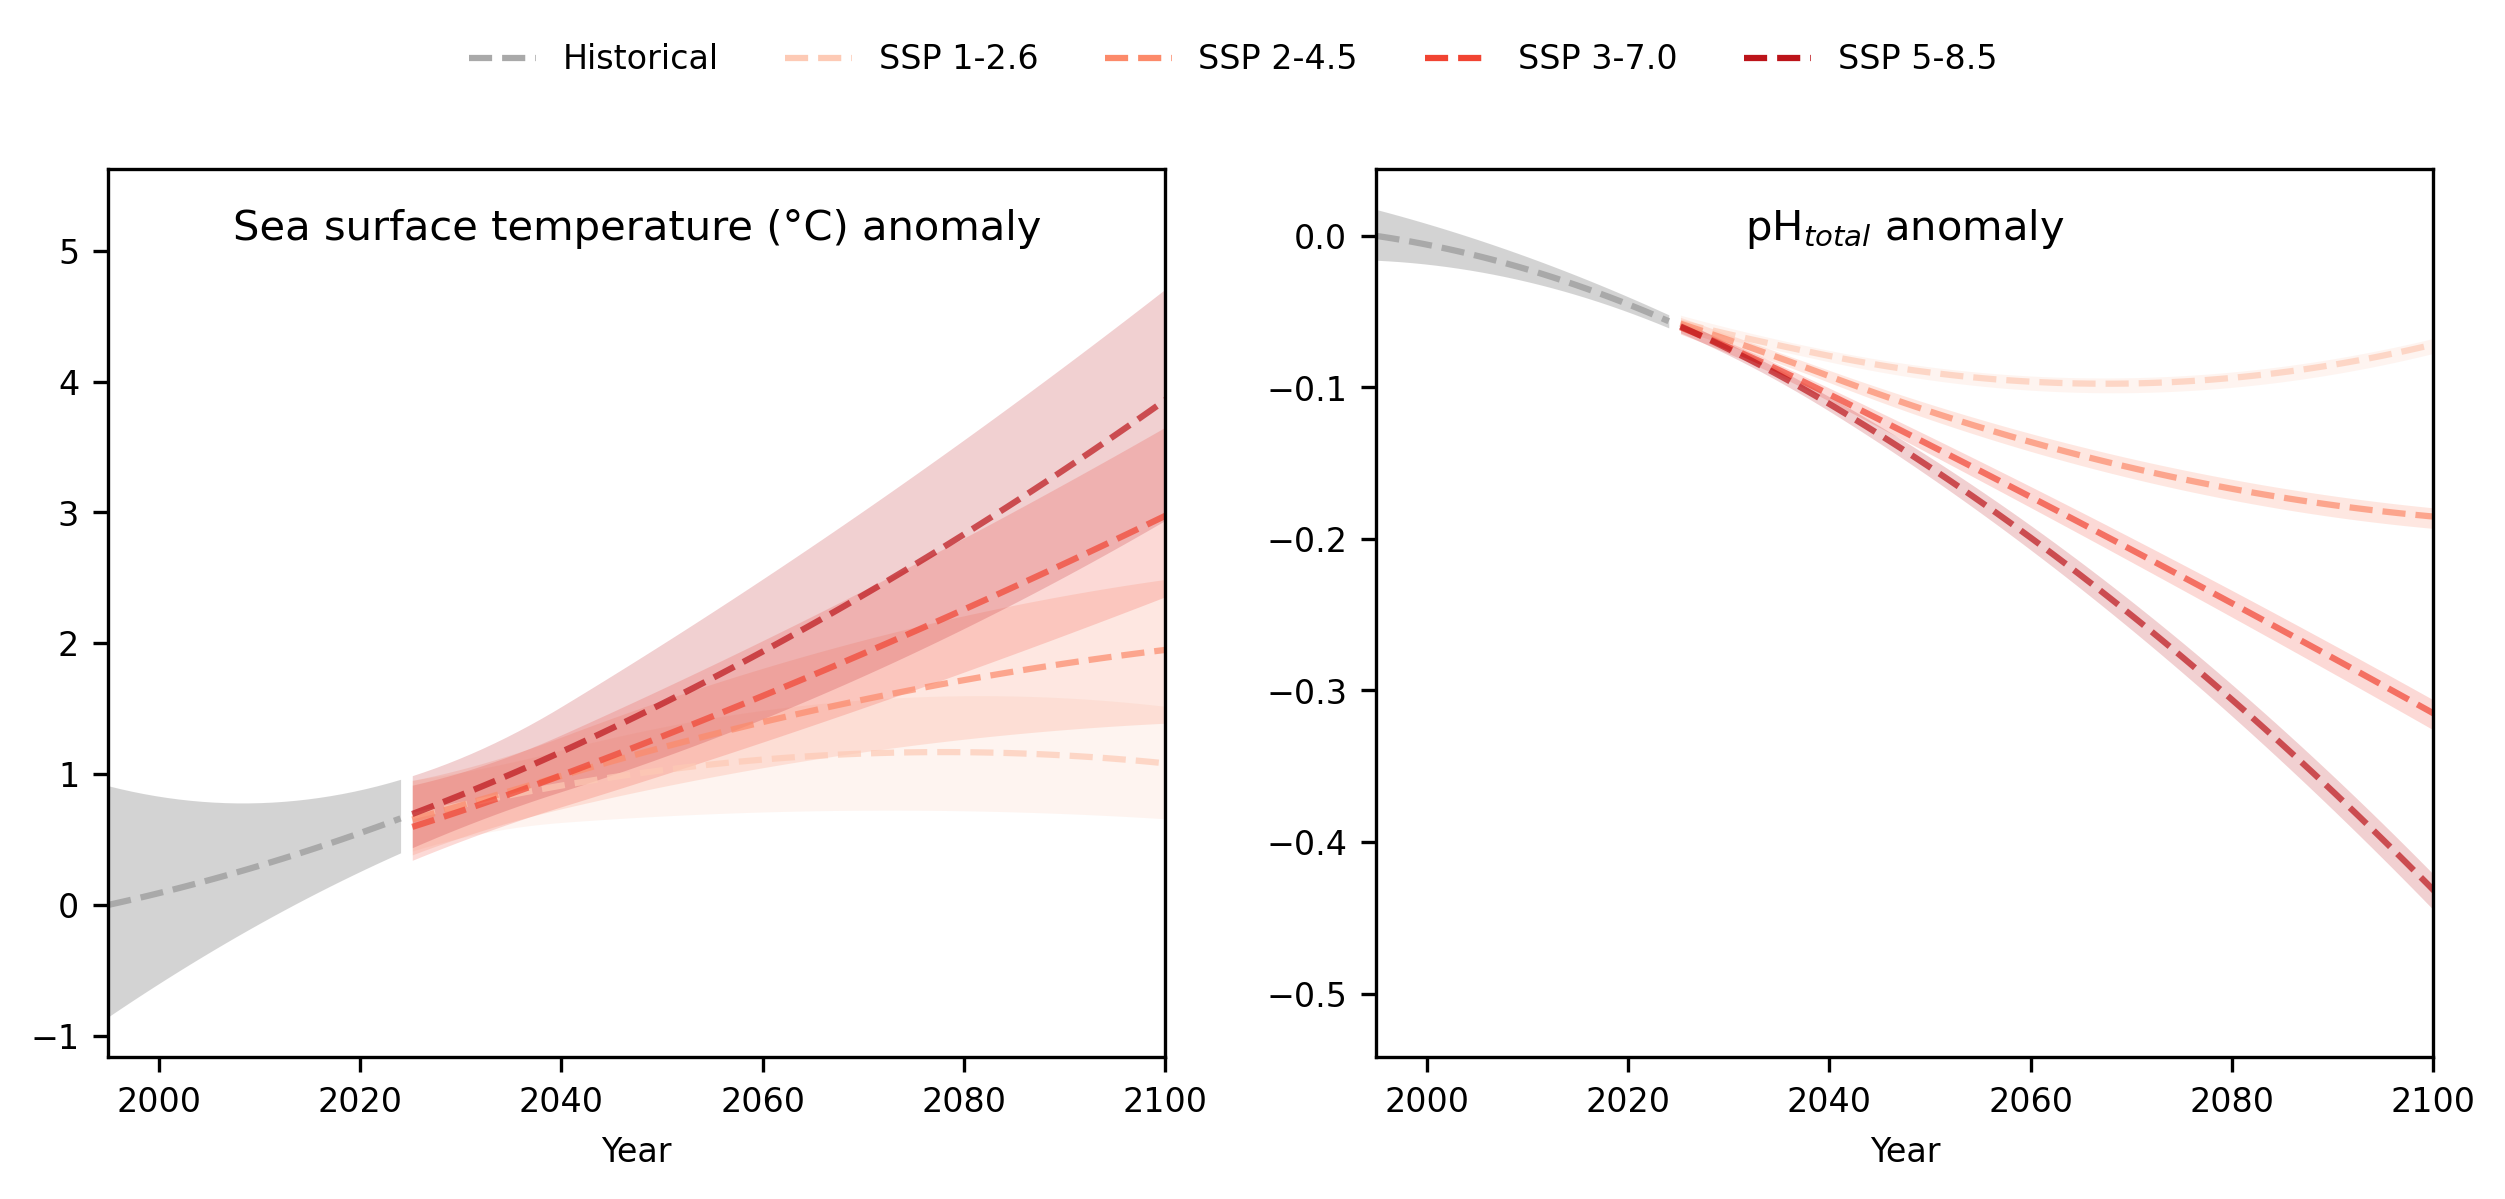

In [6]:
local_climatology_df, global_future_anomaly_df, global_anomaly_df = (
    process.process_climatology_data(
        data_df,
        config.climatology_data_dir / "ph_scenarios_output_table_site_locations.csv",
        config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv",
        config.resources_dir / "locations.yaml",
    )
)
# extrapolate climatology values to end of century
global_anomaly_df = climatology.extrapolate_df(global_anomaly_df)
# visualise climatologies until end of century
climatology_plot.plot_climate_anomalies(global_anomaly_df);

#### Filter measured calcification responses based on forecasted climatologies
To those lying within the limits of reasonable forecasts by the end of the century

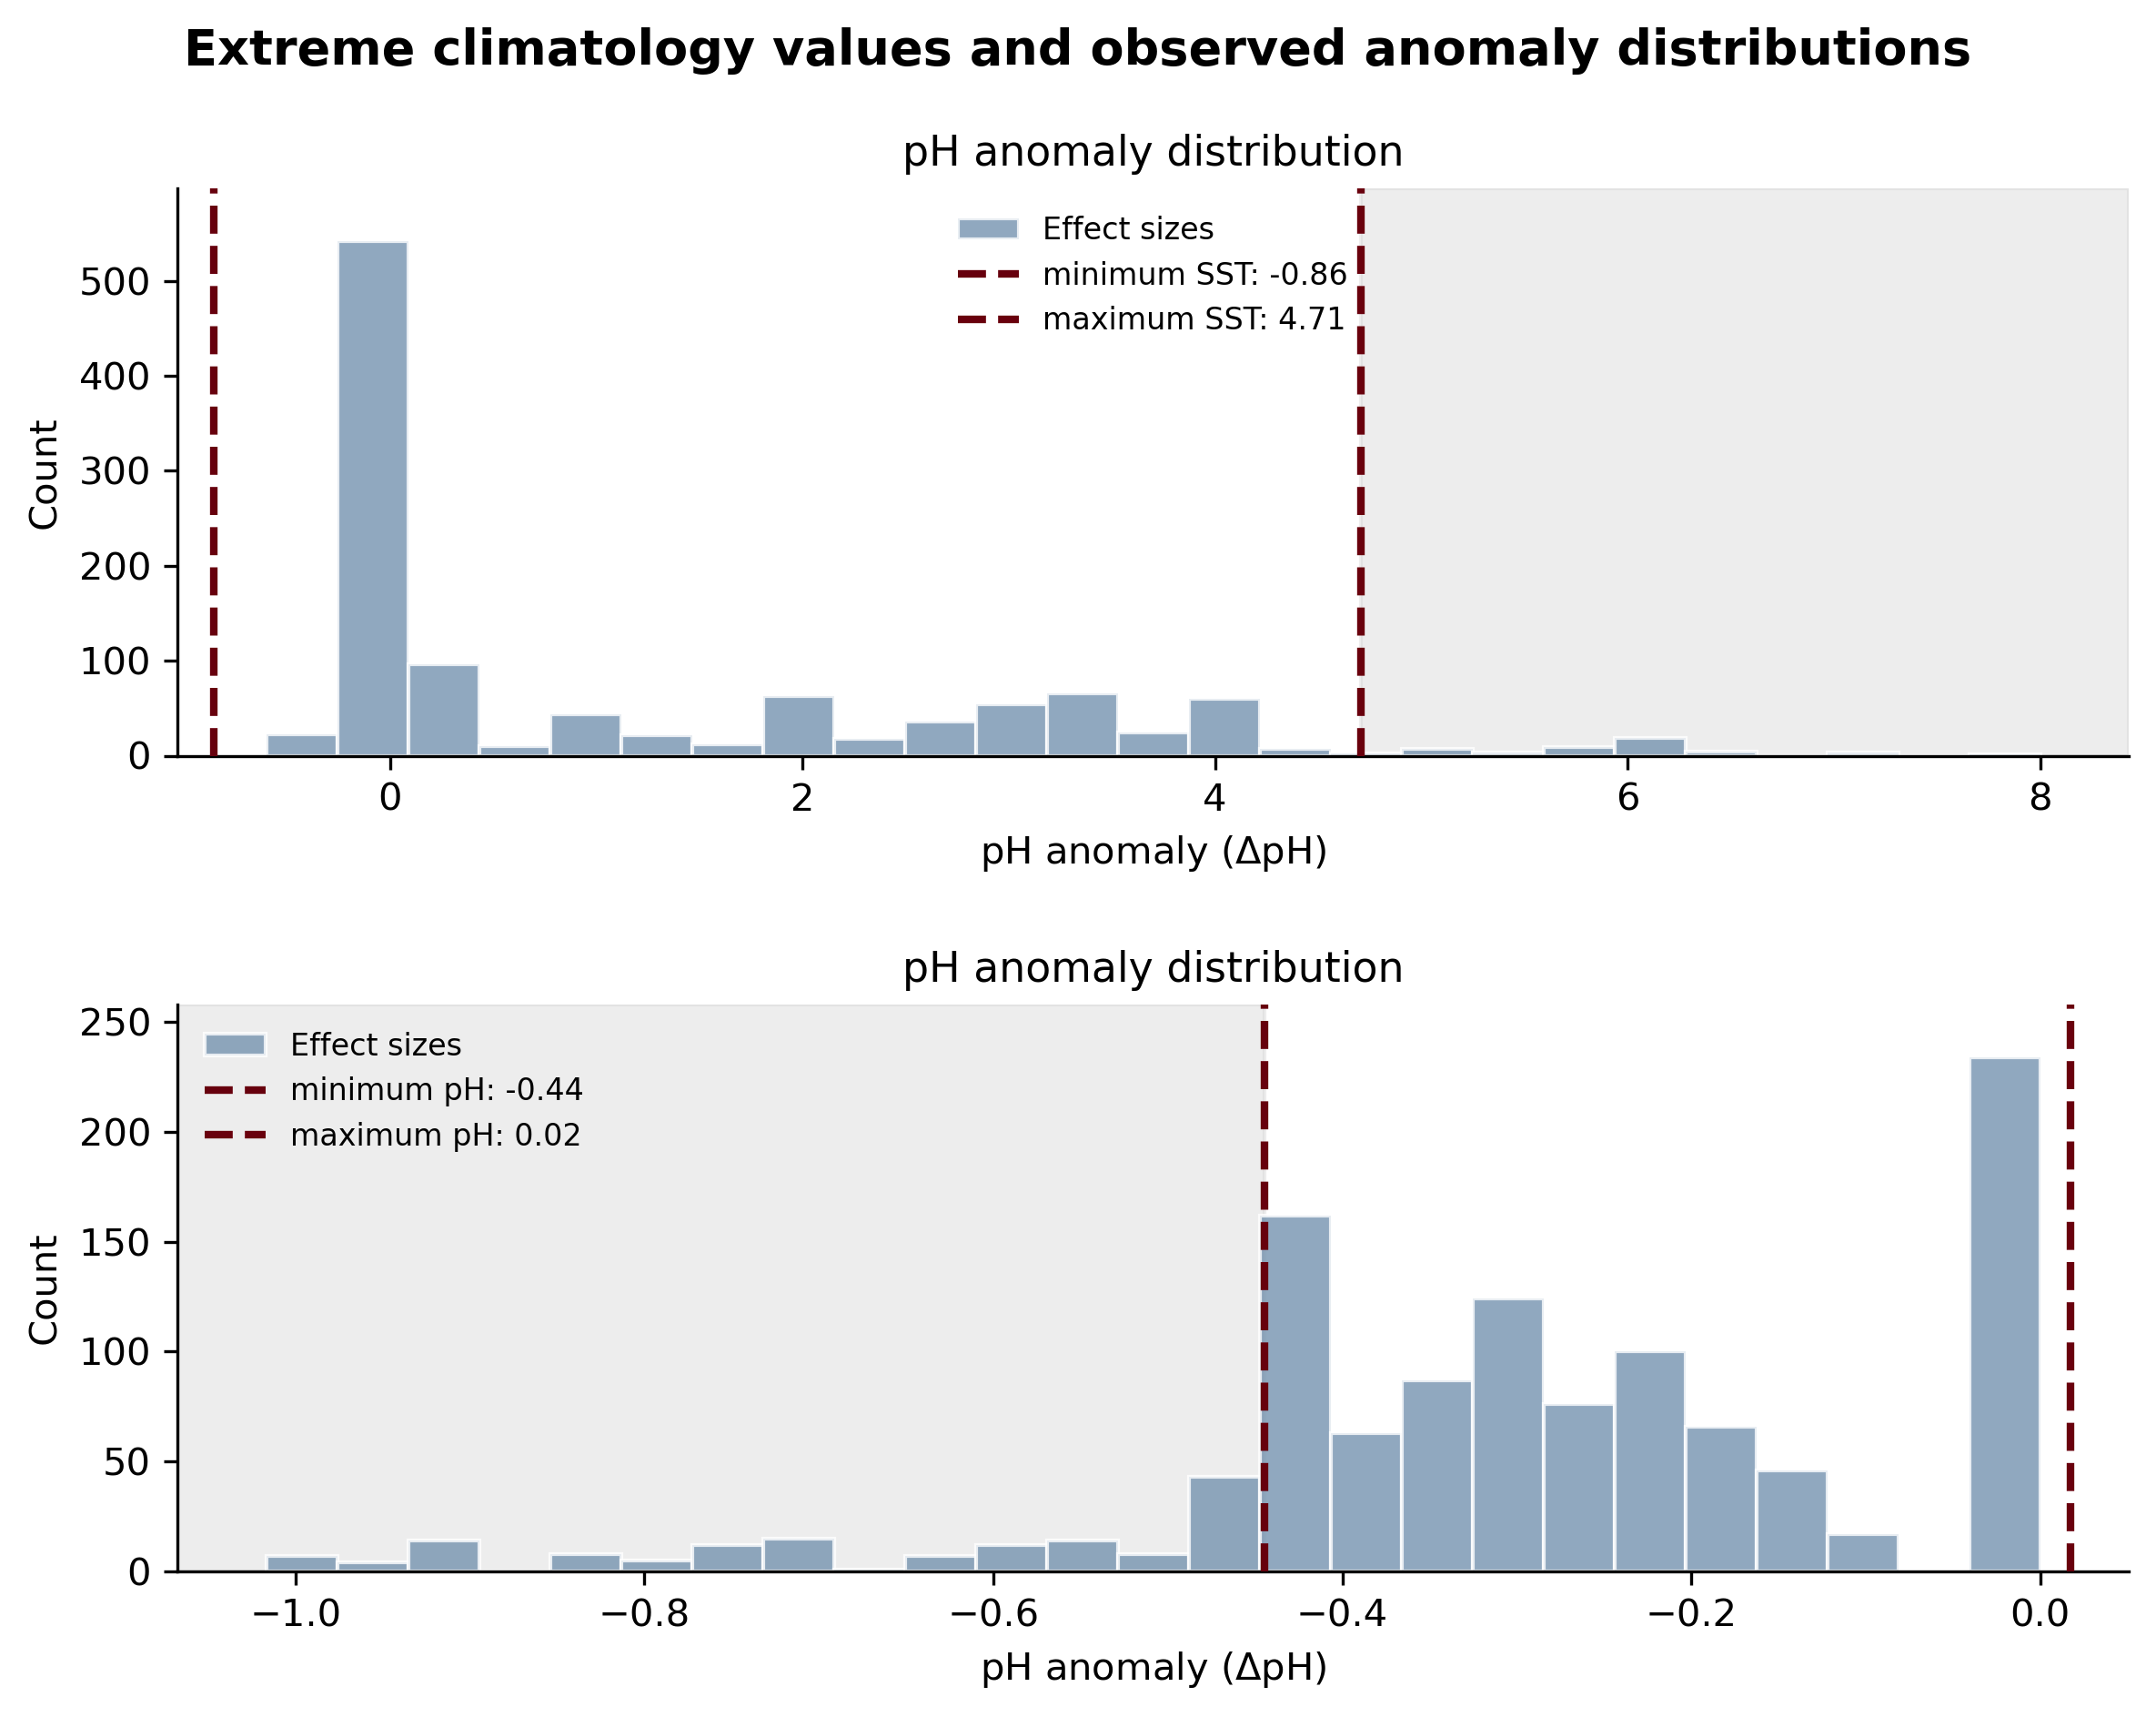

In [11]:
clim_filtered_data_df = climatology.filter_df_by_extreme_climatologies(
    data_df, global_anomaly_df
)
climatology_plot.plot_extreme_climatology_values(data_df, global_anomaly_df);

## Exploring some basic meta-analysis models